<a href="https://colab.research.google.com/github/Mogreine29/HandsOnAI_2/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
!pip install transformers
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import AutoTokenizer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import re
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive/Challenge2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/Challenge2'
/content/drive/My Drive/Challenge2


In [106]:
df_train = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Challenge2/fake_test.csv')

In [107]:
df_train = df_train.drop(['Unnamed: 0', 'target_name'], axis = 1)
df_test = df_test.drop(['Unnamed: 0', 'target_name'], axis = 1)

In [108]:
df_train.drop([1136, 1180, 1294, 1317, 1362, 1429], inplace = True )

In [109]:
df_real = pd.read_csv("real_news.csv")
df_fake = pd.read_csv("fake_news.csv")
df_real = df_real.drop(['site', 'url', 'title'], axis = 1)
df_fake = df_fake.drop(['site', 'url', 'title'], axis = 1)
df_real['label'] = 0
df_fake['label'] = 1
df_real.rename(columns = {'text':'data'}, inplace = True)
df_fake.rename(columns = {'text':'data'}, inplace = True)
df_train = df_train.append(df_real, ignore_index = True)
df_train = df_train.append(df_fake, ignore_index = True)

In [112]:
STOPWORDS = set(stopwords.words('french'))
moreStopwords = ['plus', 'comme', 'a', 'il', 'alors','au',
'aucuns','aussi','autre','avant','avec','avoir','bon','car','ce','cela','ces','ceux','chaque','ci',
'comme','comment','dans','des','du','dedans','dehors','depuis','devrait','doit','donc','dos','début',
'elle','elles','en','encore','essai','est','et','eu','fait','faites','fois','font','hors','ici','il',
'ils','je',	'juste','la','le','les','leur','là','ma','maintenant','mais','mes','mien','moins','mon',
'mot','même','ni','nommés','notre','nous','ou','où','par','parce','pas','peut','peu','plupart','pour',
'pourquoi','quand','que','quel','quelle','quelles','quels','qui','sa','sans','ses','seulement','si',
'sien','son','sont','sous','soyez',	'sujet','sur','ta','tandis','tellement','tels','tes','ton','tous',
'tout','trop','très','tu','voient','vont','votre','vous','vu','ça','étaient','état','étions','été','être']

STOPWORDS.update(moreStopwords)
def cleaner(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)

    text = ' '.join(word for word in text.split() if word not in STOPWORDS)   
    return text

In [113]:
df_train['data'] = df_train['data'].apply(cleaner)
df_test['data'] = df_test['data'].apply(cleaner)

In [114]:
df_train = df_train.append(df_test, ignore_index=True)
shuffled = df_train.sample(frac=1).reset_index()
shuffled = shuffled.drop(['index'], axis = 1)

In [115]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [116]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [117]:
tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
def preprocess_function(text):
    return tokenizer(text, truncation=True, padding=True)

In [118]:
label = shuffled.pop('label')
text = shuffled.pop('data')

In [119]:
label_arr = label.to_numpy()
text_arr = text.to_numpy()

In [120]:
for i in range(len(text_arr)):
  text_arr[i] = preprocess_function(text_arr[i]).input_ids
text_arr

array([list([5, 3444, 21, 17622, 704, 6436, 1482, 4594, 5455, 621, 732, 20517, 1482, 4594, 5455, 18822, 298, 28243, 20468, 108, 33, 362, 286, 874, 1676, 1178, 3444, 21, 17622, 6436, 1482, 4594, 5455, 20103, 704, 529, 586, 4110, 282, 3498, 526, 1359, 12949, 28243, 26516, 6783, 274, 285, 533, 256, 182, 5972, 274, 10691, 285, 1456, 529, 11604, 665, 3602, 1482, 4594, 5455, 9395, 3574, 7658, 704, 9215, 1694, 8999, 10, 20517, 18822, 298, 28243, 732, 209, 10691, 15334, 539, 421, 285, 1208, 23255, 3597, 1133, 538, 44, 12723, 15705, 4169, 1983, 2981, 410, 24299, 141, 298, 21, 22937, 16413, 5930, 2036, 85, 1910, 2294, 6436, 548, 8085, 8779, 1099, 72, 25454, 285, 1384, 5874, 12510, 2511, 3224, 6897, 3498, 526, 1359, 4328, 298, 3236, 704, 6436, 11493, 581, 2371, 1642, 15, 177, 17330, 15, 3801, 30040, 10, 1144, 6613, 10, 330, 193, 250, 10266, 2330, 11117, 6878, 10, 1343, 4996, 259, 21, 26317, 1983, 2981, 3001, 6102, 1482, 4594, 5455, 1995, 6]),
       list([5, 2542, 14091, 3972, 155, 1060, 1790, 26

In [121]:
def split_list(a_list, p):
    split = int(len(a_list)//(1/(1-p)))
    return a_list[:split], a_list[split:]
x_train, x_test = split_list(text_arr, 0.25)
y_train, y_test = split_list(label_arr, 0.25)
x_train, x_val = split_list(x_train, 0.30)
y_train, y_val = split_list(y_train, 0.30)

In [122]:
maxlen = 200  # Only consider the first 200 words of each movie review
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

11080 Training sequences
4750 Validation sequences


In [123]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
vocab_size = 210000

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [131]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 32)          6726400   
 g_6 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_6 (Transf  (None, 200, 32)          10656     
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_6   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_26 (Dropout)        (None, 32)                0   

In [124]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=20, validation_data=(x_val, y_val)
)

Epoch 1/20
347/347 [==============================] - 82s 232ms/step - loss: 0.4547 - accuracy: 0.7702 - val_loss: 0.2429 - val_accuracy: 0.8964
Epoch 2/20
347/347 [==============================] - 69s 200ms/step - loss: 0.1495 - accuracy: 0.9504 - val_loss: 0.1760 - val_accuracy: 0.9328
Epoch 3/20
347/347 [==============================] - 68s 196ms/step - loss: 0.0533 - accuracy: 0.9843 - val_loss: 0.3017 - val_accuracy: 0.9206
Epoch 4/20
347/347 [==============================] - 70s 201ms/step - loss: 0.0271 - accuracy: 0.9940 - val_loss: 0.2794 - val_accuracy: 0.9375
Epoch 5/20
347/347 [==============================] - 69s 199ms/step - loss: 0.0120 - accuracy: 0.9971 - val_loss: 0.4106 - val_accuracy: 0.9272
Epoch 6/20
347/347 [==============================] - 68s 197ms/step - loss: 0.0150 - accuracy: 0.9961 - val_loss: 0.3516 - val_accuracy: 0.9349
Epoch 7/20
347/347 [==============================] - 69s 198ms/step - loss: 0.0144 - accuracy: 0.9964 - val_loss: 0.3140 - val_ac

In [125]:
savepath = '/content/drive/MyDrive/Challenge2/transformer_weights1.h5'

In [126]:
model.save_weights(savepath)

In [127]:
print("Accuracy of the model on Training Data is - " , model.evaluate(x_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Validating Data is - " , model.evaluate(x_val,y_val)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

347/347 [==============================] - 16s 46ms/step - loss: 0.0020 - accuracy: 0.9997
Accuracy of the model on Training Data is -  99.97292160987854 %
149/149 [==============================] - 7s 45ms/step - loss: 0.7171 - accuracy: 0.9251
Accuracy of the model on Validating Data is -  92.50526428222656 %
165/165 [==============================] - 8s 46ms/step - loss: 0.7883 - accuracy: 0.9170
Accuracy of the model on Testing Data is -  91.69982671737671 %


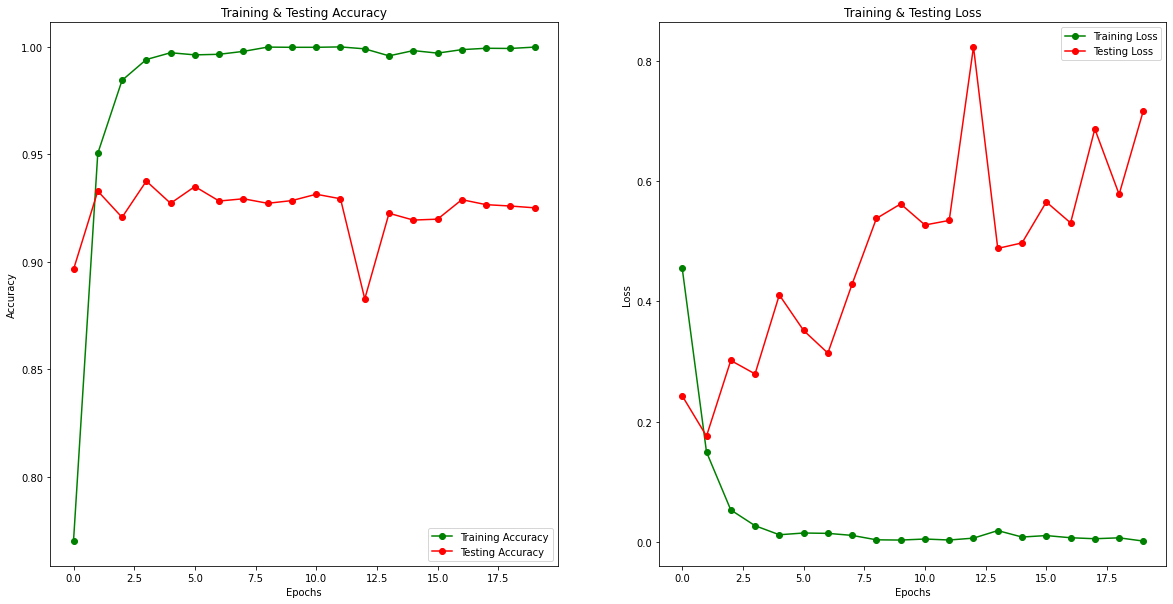

In [128]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()